In [1]:
# https://stackoverflow.com/questions/45741878/using-binary-crossentropy-loss-in-keras-tensorflow-backend
# https://www.machinecurve.com/index.php/2019/10/22/how-to-use-binary-categorical-crossentropy-with-keras/

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, CuDNNGRU
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext tensorboard
import datetime

!rm -rf ./logs/

tf.config.experimental.list_physical_devices('GPU')

# RNN based Models (RNN & LSTM & GRU) using tensorflow keras

2021-10-24 22:35:23.111774: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2021-10-24 22:35:24.449233: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2021-10-24 22:35:25.039396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-24 22:35:25.039979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2021-10-24 22:35:25.040019: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2021-10-24 22:35:25.043296: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2021-10-24 22:35:25.044921: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2021-10-24 22:35:25.045247: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so.10
20

In [2]:
#normalize X values to help model converge
def normalize(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    data = (data - mean) / std
    return data

In [3]:
def convert_3D(matrix):
    return np.expand_dims(matrix, -1)

In [4]:
#retrieve and format data - into labels and examples from the dataset
def features_and_labels(filename):
    data = np.matrix(pd.read_csv(filename).values)

    #we need to transpose data sets to be compatable with our weight vectors
    data_y = data[:, 0]
    data_y-=1 #binaryization of the categorical data

    data_x = data[:, 1:]
    data_x = convert_3D(normalize(data_x))
    return data_x, data_y

In [5]:
training_data_x, training_data_y = features_and_labels("../archive/exoTrain.csv")
test_x, test_y = features_and_labels("../archive/exoTest.csv")

training_data_x, validation_data_x, training_data_y, validation_data_y = train_test_split(training_data_x, training_data_y, test_size=0.3)

In [6]:
GRUmodel = Sequential([
    CuDNNGRU(4, input_shape=(training_data_x.shape[1:]), return_sequences=True),
    CuDNNGRU(4),
    Dense(1)
])

GRUmodel.compile(
    loss=BinaryCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = GRUmodel.fit(training_data_x, training_data_y, epochs=20, validation_data=(validation_data_x,validation_data_y), , callbacks=[tensorboard_callback])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3560 samples, validate on 1527 samples


2021-10-24 22:35:29.834618: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2021-10-24 22:35:29.834938: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x564a22111c10 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-10-24 22:35:29.834970: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-10-24 22:35:29.916036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-24 22:35:29.916884: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x564a226208c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-10-24 22:35:29.916915: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2021-10-24

Epoch 1/3


2021-10-24 22:35:30.638927: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2021-10-24 22:35:31.117510: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.8


3560/3560 [==============================] - 33s 9ms/sample - loss: 0.3644 - acc: 0.9921 - val_loss: 0.0878 - val_acc: 0.9935
Epoch 2/3
3560/3560 [==============================] - 17s 5ms/sample - loss: 0.0684 - acc: 0.9924 - val_loss: 0.0548 - val_acc: 0.9935
Epoch 3/3
3560/3560 [==============================] - 17s 5ms/sample - loss: 0.0546 - acc: 0.9924 - val_loss: 0.0480 - val_acc: 0.9935


In [ ]:
%tensorboard --logdir logs/fit

570/570 [==============================] - 12s 20ms/sample - loss: 0.0576 - acc: 0.9912


[0.05756008621762719, 0.99122804]

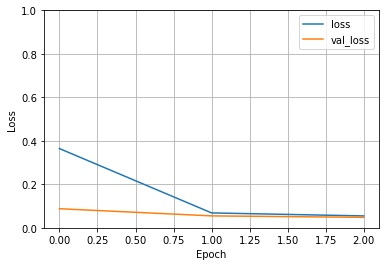

In [7]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

GRUmodel.evaluate(test_x, test_y, batch_size=64)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1c58af11-5d4f-40f3-a808-e868f2c28485' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>